In [12]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from collections.abc import MutableMapping

from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize
import pickle

plt.style.use('ggplot')

mne.set_log_level(verbose=False)

In [13]:
subjects = [file.split('.')[0] for file in os.listdir('RT_epochs') if file.endswith('.fif')]
epoch_paths = [os.path.join('RT_epochs', file) for file in os.listdir('RT_epochs') if file.endswith('.fif')]

In [14]:
class BTS_ERP(MutableMapping):
    
    def __init__(self, subject, *args, **kwargs):
        self.subject = subject
        self.epochs = dict()
        self.update(dict(*args, **kwargs))
        
    def __getitem__(self, event_id):
        return self.epochs[event_id]

    def __setitem__(self, event_id, epoch):
        self.epochs[event_id] = epoch

    def __delitem__(self, event_id):
        del self.epochs[event_id]

    def __iter__(self):
        return iter(self.epochs)

    def __len__(self):
        return len(self.epochs)
    
    def __repr__(self):
        
        return 'Subject: {}, slow: {}, med: {}, fast: {}'.format(self.subject, self.epochs['0'].shape[0], 
                                                                              self.epochs['3'].shape[0],
                                                                             self.epochs['1'].shape[0]) 
    
    def get_data(self):
        
        data = []
        
        for i,epoch in enumerate(self.epochs.values()):
            if len(epoch) == 0:
                continue
            if len(data) == 0:
                data = epoch
                continue

            data = np.append(data, epoch, axis=0)
            
        return data
    
    def get_metadata(self):
        
        meta = []
        
        for event in self.epochs:
            no_trials = len(self.epochs[event])
            
            if no_trials == 0:
                continue
            m = no_trials * [[self.subject, event]]
            
            meta.extend(m)
            
        return np.array(meta)

In [4]:
def drop_trials(trials, sampledtrials, n_dr):
    
    dr_trials = np.random.choice(sampledtrials, size=n_dr)
    
    for dr_trial in dr_trials:
        
        trial_index = np.where(trials == dr_trial)[0]
        
        trials = np.delete(trials, trial_index)
        
    return trials

def bootstrap(epochs, event_ids, subject, rate=10, iter=1200, 
              dropout = None, trial_dr_div=10):
    
    bts = BTS_ERP(subject)
    
    for event_id in event_ids:
        
        if event_id == '2':
            continue           
        
        epocharray = epochs[event_id].get_data()
        
        n_trials = epocharray.shape[0]
        
        if dropout is None:
            dr = 0
        else:
            dr = dropout[event_id]
                    
        n_dr = int(rate * dr) 
        
        trials = np.arange(0, n_trials)
        
        btserps = []
        
        for i in range(iter):
            
            if len(trials) <= rate:
                btserps.append(np.average(epocharray[trials], axis=0))
                break
            
            sampledtrials = np.random.choice(trials, size=rate)
            sampledepochs = epocharray[sampledtrials]
            btserp = np.average(sampledepochs, axis=0)
            
            btserps.append(btserp)
            
            if i % trial_dr_div == 0:      
                trials = drop_trials(trials, sampledtrials, n_dr)
                
            
        bts[event_id] = np.array(btserps)
        
    return bts

def save_btserp(bts, subject, folder='bts_erp', rate=None):
    
    if rate is not None:
        folder = '{}_{}'.format(folder, rate)
        
    if not os.path.exists(folder):
        os.mkdir(folder)
    subject = subject + '.pkl'
        
    save_path = os.path.join(folder, subject)
    
    with open(save_path, 'wb') as f:
        pickle.dump(bts, f)

In [5]:
rate = [10, 30, 50]

dr_dict = {
    10 : {'0': 0.1, '1': 0.3, '3': 0.2},
    30 : {'0': 0.2, '1': 0.4, '3': 0.3},
    50 : {'0': 0.2, '1': 0.5, '3': 0.3}
}

trial_drs = [10, 15, 20]

for dr_key, trial_dr_div, r in tqdm(zip(dr_dict, trial_drs, rate)):
    dr = dr_dict[dr_key]
    for path, sub in tqdm(zip(epoch_paths, subjects)):
        single_trials = mne.read_epochs(path, verbose=False)
        bts = bootstrap(single_trials, ['0', '1', '3'], sub, dropout=dr, trial_dr_div=trial_dr_div)
        save_btserp(bts, sub, rate=r)

In [297]:
slow = 0
med = 0
fast = 0

folder_path = 'filtered_bts_erp_10/'
for sub in tqdm(subjects):
    path = os.path.join(folder_path, sub + '.pkl')
    
    with open(path, 'rb') as f:
        erp = pickle.load(f)
    
    slow += len(erp['0'])
    med += len(erp['3'])
    fast += len(erp['1'])
    
print('slow: {}, med: {}, fast: {}, total: {}'.format(slow, med, fast, slow+med+fast))


slow: 25829, med: 41660, fast: 52993, total: 120482


In [237]:
slow + med + fast

133870

### PCA Decomposition (ERP)

In [6]:
from sklearn.decomposition import PCA
from sklearn import metrics

In [7]:
def compute_recon_error(rate=10, n_components=2):
   
    for i, sub in tqdm(enumerate(subjects)):

        eeg_path = 'RT_epochs/' + sub + '.fif'

        btserp_path = 'bts_erp_{}/'.format(rate) + sub + '.pkl'

        eeg_trials = mne.read_epochs(eeg_path, verbose=False).get_data()

        with open(btserp_path, 'rb') as f:
            btserp = pickle.load(f)
        
        btserp_trials = btserp.get_data()
        
        meta = btserp.get_metadata()
        
        

        eeg_trials = eeg_trials.reshape((eeg_trials.shape[0], -1))
        btserp_trials = btserp_trials.reshape((btserp_trials.shape[0], -1))

        pca = PCA(copy=False)
        pca.fit(eeg_trials)

        eeg_eigen = pca.transform(eeg_trials)
        eeg_recon = pca.inverse_transform(eeg_eigen)

        btserp_eigen = pca.transform(btserp_trials)
        btserp_recon = pca.inverse_transform(btserp_eigen)

        eeg_recon_error = np.mean((eeg_trials - eeg_recon) ** 2, axis=1)
        btserp_recon_error = np.mean((btserp_trials - btserp_recon) ** 2, axis=1)
        
        save_path_eeg_error = 'eeg_recon_error/'
        btserp_path_eeg_error = 'btserp_recon_error{}/'.format(rate)
        
        if not os.path.exists(save_path_eeg_error):
            os.mkdir(save_path_eeg_error)
            
        if len(os.listdir(save_path_eeg_error)) != 50:
            eeg_recon_path = save_path_eeg_error + sub.split('-')[0] + '.npy'
            np.save(eeg_recon_path, eeg_recon_error)
            
        if not os.path.exists(btserp_path_eeg_error):
            os.mkdir(btserp_path_eeg_error)
        
        btserp_recon_error = np.append(meta, btserp_recon_error[..., np.newaxis], axis=1)
        
        trials = np.arange(0, len(btserp_recon_error))
        
        btserp_recon_error = np.append(btserp_recon_error, trials[..., np.newaxis], axis=1)
        
        btserp_recon_error = btserp_recon_error[:, [2,0,1,3]]
        
        btserp_recon_path = btserp_path_eeg_error + sub.split('-')[0] + '.npy'
        
        np.save(btserp_recon_path, btserp_recon_error)
        
        

In [8]:
for r in tqdm(rate):
    compute_recon_error(r)

In [15]:
rate = [10, 30, 50]
eeg_error = []
btserp_errors = dict()

for i,r in tqdm(enumerate(rate)):  
    btserp_error = []
    
    for sub in tqdm(subjects):
        if i == 0:
            eeg_recon_path = 'eeg_recon_error/' + sub.split('-')[0] + '.npy'
            eeg_error = np.append(eeg_error, np.load(eeg_recon_path, allow_pickle=True))

        btserp_recon_path = 'btserp_recon_error{}/'.format(r) + sub.split('-')[0] + '.npy'

        
        btserp_error = np.append(btserp_error, np.load(btserp_recon_path, allow_pickle=True))
    
    btserp_errors[r] = btserp_error.reshape((-1, 4))
    

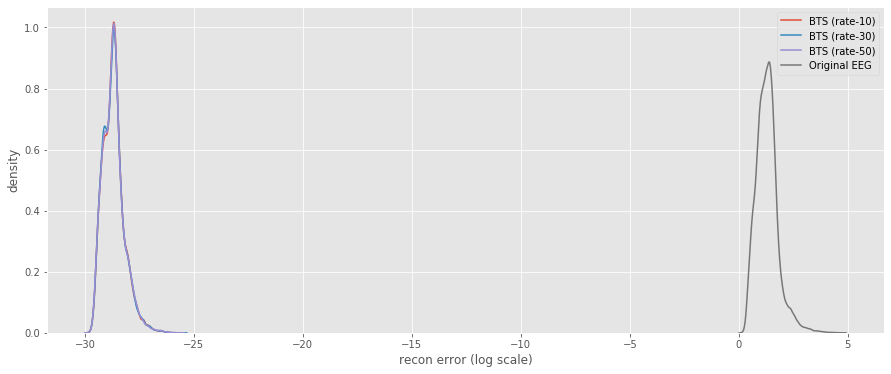

In [24]:
plt.figure(figsize=(15,6))

for r in rate:
    bts_errors = np.log10(btserp_errors[r][:,0].astype(np.float32))
    sns.distplot(bts_errors, hist=False, label='BTS (rate-{})'.format(r))
    
sns.distplot(np.log10(eeg_error), hist=False, label='Original EEG')

plt.xlabel('recon error (log scale)')
plt.ylabel('density')
plt.legend()    

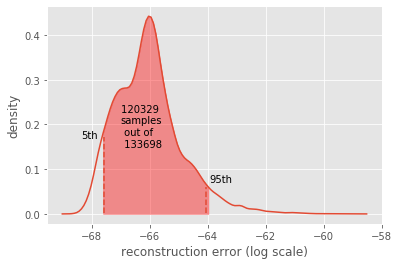

In [10]:
plt.figure()
error10 =np.log(btserp_errors[10][:, 0].astype(np.float32))
points = sns.distplot(error10, hist=False).get_lines()[0].get_data()
x, y = points

p5 = np.percentile(error10, 5)
p95 = np.percentile(error10, 95)

no_samples = len(error10[(error10 >= p5) & (error10 <= p95)])

shade = plt.fill_between(x, y, where=(x>=p5) & (x<=p95), color='r', alpha=0.4)

plt.text(p5-0.7, 0.17, '5th')
plt.text(p95, 0.07, '95th')

plt.axvline(p5+0.1, ymin=0.05, ymax=0.4, linestyle='--')
plt.axvline(p95-0.1, ymin=0.05, ymax=0.17, linestyle='--')

plt.xlabel('reconstruction error (log scale)')
plt.ylabel('density')

plt.text(-67, 0.15, '{} \nsamples\n out of\n {}'.format(no_samples, len(error10)))

plt.show()

In [11]:
btserp10 = pd.DataFrame(btserp_errors[10], columns=['recon_error', 'sub', 'RT', 'trial_no'])
btserp10['recon_error'] = btserp10[['recon_error', 'trial_no']].apply(pd.to_numeric)

btserp10_filtered = btserp10[(np.log(btserp10['recon_error']) >= p5) 
                             & (np.log(btserp10['recon_error']) <= p95)]
btserp10_filtered.to_csv('recon_error10_filtered.csv', index=False)

In [12]:
def filter_btserp(rate=10):
    events = ['0', '1', '3']
    recon_error_path = 'recon_error{}_filtered.csv'.format(rate)
    meta = pd.read_csv(recon_error_path)[['trial_no', 'sub', 'RT']].values
    
    for i, sub in tqdm(enumerate(subjects)):
        filtered_bts = BTS_ERP(sub)
        
        sub_meta = meta[meta[:, 1] == sub]
        trial_ids = sub_meta[:, 0].astype(np.int)
        
#         print(trial_ids[sub_meta[:, 2].astype(str) == '0'])
#         print(sub)
        
        btserp_path = 'bts_erp_{}/'.format(rate) + sub + '.pkl'

        with open(btserp_path, 'rb') as f:
            btserp = pickle.load(f)
            btserp_epoch = btserp.get_data()
        
        for event in events:
            event_trials = trial_ids[sub_meta[:, 2].astype(str) == event]
#             print(event_trials.max(), btserp_epoch.shape[0])
            filtered_epochs = btserp_epoch[event_trials]
            filtered_bts[event] = filtered_epochs
        save_btserp(filtered_bts, sub, 'filtered_bts_erp', rate=10)

In [13]:
filter_btserp()

## Band Power Calculation

In [7]:
from MNE_Pipeline_ext import MNE_Repo_Mat_ext
from MNE_Pipeline import MNE_Repo_Mat


import re

In [15]:
mp = MNE_Repo_Mat()
info = mp.construct_info()
mp.Fs = 500

/home/kam/anaconda3/envs/mne/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/home/kam/anaconda3/envs/mne/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/kam/Bootstrap_EEG/MNE_Pipeline.py:57: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif`

In [40]:
folder_path = 'filtered_bts_erp_10/'
save_path = 'bandpower'
for sub in tqdm(subjects):
    path = os.path.join(folder_path, sub + '.pkl')
    
    with open(path, 'rb') as f:
        erps = pickle.load(f)
    
    bts_bp = BTS_ERP(sub)
    
    for event_id in erps:
        mp.epochs_raw = erps[event_id]
        bp = mp.get_avg_band_power(tmin=-0.2, tmax=0.8)
        
        bts_bp[event_id] = bp
        
        mp.epochs_raw = None
    save_btserp(bts_bp, sub, save_path, 10)

## Topomap Generation

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from multiprocessing import Process
import cv2
import re

from MNE_Pipeline import MNE_Repo_Mat


mp = MNE_Repo_Mat()
info = mp.construct_info()

/home/kam/anaconda3/envs/mne/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/home/kam/anaconda3/envs/mne/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/kam/Bootstrap_EEG/MNE_Pipeline.py:57: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif`

In [7]:
def load_bps_with_meta(folder_path):
    metas = []
    bps = []
    for i,sub in tqdm(enumerate(subjects)):
        
        path = os.path.join(folder_path, sub) + '.pkl'
        with open(path, 'rb') as f:
            bts = pickle.load(f)
        
        
#         print(sub)
        bp = bts.get_data()
        
        meta = bts.get_metadata()
        
        if i == 0:
            bps = bp
            metas = meta
            continue
        bps = np.append(bps, bp, axis=0)
        metas = np.append(metas, meta, axis=0)
        
    bp_data = np.hstack((metas, bps))
    
    ch = ['{}-CH{}'.format(band, i+1) for band in ['alpha', 'beta', 'gamma'] for i in range(64)]
    columns = ['sub', 'RT']
    columns.extend(ch)
    bp_df = pd.DataFrame(bp_data, columns=columns)
        
    return bp_df

def combine_topomaps(alpha_path, beta_path, gamma_path, _class, folder_path):
    full_path_w_class = os.path.join(folder_path, str(_class))
    
    if not os.path.exists(full_path_w_class):
        os.makedirs(full_path_w_class)
        
    alpha_path = os.path.join(alpha_path, str(_class))
    beta_path = os.path.join(beta_path, str(_class))
    gamma_path = os.path.join(gamma_path, str(_class))
    
        
    alpha_imgs = [os.path.join(alpha_path, img_id) for img_id in os.listdir(alpha_path)]
    beta_imgs = [os.path.join(beta_path, img_id) for img_id in os.listdir(beta_path)]
    gamma_imgs = [os.path.join(gamma_path, img_id) for img_id in os.listdir(gamma_path)]
    
    trials = os.listdir(alpha_path)
    
    for path_alpha, path_beta, path_gamma, trial_no in tqdm(zip(alpha_imgs, beta_imgs, gamma_imgs, trials)):
        
        trial_no = int(re.search(r'\d+', trial_no).group())
        
        img_alpha = cv2.imread(path_alpha, cv2.IMREAD_GRAYSCALE)
        img_beta = cv2.imread(path_beta, cv2.IMREAD_GRAYSCALE)
        img_gamma = cv2.imread(path_gamma, cv2.IMREAD_GRAYSCALE)
        
        combined_img = np.dstack((img_alpha, img_beta, img_gamma))
        
        save_path = os.path.join(full_path_w_class, 'bts_{}.png'.format(trial_no))
        
        cv2.imwrite(save_path, combined_img)
    

def gen_topomap(avg_band_pw_data, labels, classes, trial_names, vmax, vmin, folder_path, start, end):
    
    for _class in classes:
        full_path_w_class = os.path.join(folder_path, str(_class))
        if not os.path.exists(full_path_w_class):
            os.makedirs(full_path_w_class)
    
    for i in range(start, end):
        save_path = os.path.join(folder_path, str(labels[i]), trial_names[i])
        topo , _ = mne.viz.plot_topomap(avg_band_pw_data[i], vmax=vmax[i], vmin=vmin[i],
                                        pos=info, res=256, show=False, contours=0)

        topo.get_figure().savefig(save_path, dpi=64)
    

def async_gen_topomap(x, y, classes, trial_names, vmax, vmin, start, end, folder, t='train'):
    
    alpha = x[:, 0:64]
    beta = x[:, 64:128]
    gamma = x[:, 128:192]
    
    n = list(range(start, end, 50))
    n.append(end)
    processes = []
    for i in range(len(n) - 1):
        process_alpha = Process(target=gen_topomap, 
                                args=(alpha, y, classes, trial_names, vmax, vmin, 
                                      os.path.join(folder, t, 'alpha'), n[i], n[i+1]))
        process_beta = Process(target=gen_topomap, 
                               args=(beta, y, classes, trial_names, vmax, vmin,
                                     os.path.join(folder, t, 'beta'), n[i], n[i+1]))
        process_gamma = Process(target=gen_topomap, 
                                args=(gamma, y, classes, trial_names, vmax, vmin,
                                      os.path.join(folder, t, 'gamma'), n[i], n[i+1]))

        process_alpha.start()
        process_beta.start()
        process_gamma.start()


        processes.extend([process_alpha, process_beta, process_gamma])
        
    for process in processes:
        process.join()

In [6]:
data_bp = load_bps_with_meta('bandpower_10')

In [8]:
columns = ['sub']

ch = ['{}-CH{}'.format(band, i+1) for band in ['alpha', 'beta', 'gamma'] for i in range(64)]


sub = data_bp['sub'].values[..., np.newaxis]
X = data_bp[ch].values
Y = data_bp['RT'].values.astype(np.int)

# scaler = MinMaxScaler()

# X = scaler.fit_transform(X)

X = np.hstack((sub, X))

trial_ids = np.array(['bts_{}.png'.format(i + 1) for i in range(len(X))])[..., np.newaxis]

X = np.hstack((trial_ids, X)) 

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=33, test_size=0.33, stratify=sub)



np.save('x_train.npy', x_train)
np.save('x_test.npy', x_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

# trial_train = x_train[:, 0]
# trial_test = x_test[:, 0]

# x_train = x_train[:, 2:194].astype(np.float32)
# x_test = x_test[:, 2:194].astype(np.float32)

In [8]:

x_train = np.load('x_train.npy', allow_pickle=True)
x_test = np.load('x_test.npy', allow_pickle=True)

trial_train = x_train[:, 0]
trial_test = x_test[:, 0]

x_train = x_train[:, 2:194].astype(np.float64)
x_test = x_test[:, 2:194].astype(np.float64)


y_train = np.load('y_train.npy', allow_pickle=True)
y_test = np.load('y_test.npy', allow_pickle=True)

In [9]:
vmax_train, vmin_train = np.max(x_train, axis=1), np.min(x_train, axis=1)
vmax_test, vmin_test = np.max(x_test, axis=1), np.min(x_test, axis=1)

In [10]:
#Train
indices = list(range(0, len(x_train), 1000))

indices.append(len(x_train))

for i in tqdm(range(len(indices) - 1)):
    async_gen_topomap(x_train, y_train, [0,1,3], trial_train, vmax_train, vmin_train,
                      indices[i], indices[i+1], 'topomaps_RT_50_w_sub_h1', t='train')
    
#test
indices = list(range(0, len(x_test), 1000))

indices.append(len(x_test))

for i in tqdm(range(len(indices) - 1)):
    async_gen_topomap(x_test, y_test, [0,1,3], trial_test, vmax_test, vmin_test,
                      indices[i], indices[i+1], 'topomaps_RT_50_w_sub_h1', t='test')

In [11]:
combine_topomaps('topomaps_RT_50_w_sub_h1/train/alpha', 'topomaps_RT_50_w_sub_h1/train/beta', 
                 'topomaps_RT_50_w_sub_h1/train/gamma', 0, 'topomaps_RT_50_w_sub_h1/train/combined')

combine_topomaps('topomaps_RT_50_w_sub_h1/train/alpha', 'topomaps_RT_50_w_sub_h1/train/beta', 
                 'topomaps_RT_50_w_sub_h1/train/gamma', 1, 'topomaps_RT_50_w_sub_h1/train/combined')

combine_topomaps('topomaps_RT_50_w_sub_h1/train/alpha', 'topomaps_RT_50_w_sub_h1/train/beta', 
                 'topomaps_RT_50_w_sub_h1/train/gamma', 3, 'topomaps_RT_50_w_sub_h1/train/combined')


combine_topomaps('topomaps_RT_50_w_sub_h1/test/alpha', 'topomaps_RT_50_w_sub_h1/test/beta', 
                 'topomaps_RT_50_w_sub_h1/test/gamma', 0, 'topomaps_RT_50_w_sub_h1/test/combined')

combine_topomaps('topomaps_RT_50_w_sub_h1/test/alpha', 'topomaps_RT_50_w_sub_h1/test/beta', 
                 'topomaps_RT_50_w_sub_h1/test/gamma', 1, 'topomaps_RT_50_w_sub_h1/test/combined')

combine_topomaps('topomaps_RT_50_w_sub_h1/test/alpha', 'topomaps_RT_50_w_sub_h1/test/beta', 
                 'topomaps_RT_50_w_sub_h1/test/gamma', 3, 'topomaps_RT_50_w_sub_h1/test/combined')